Quick Statistics Exercise
===

The file `gen_data.sh` quickly generates 1,000 Cartesian (two-column x,y) data files of sinsoidal signals with an additive white Gaussian noise component. 

This ipython notebook explores how to quickly read those data files into memory and perform operations on them.

In [1]:
# Standard module imports and Jupyter magics
%matplotlib inline
import sys
sys.path.append('../common')
from plt_style import *
import glob,natsort
import tqdm

In [2]:
# Scientific/Numerical modules required by exercise
import numpy as np
import pylab as plt

In [3]:
# Generate synthetic data for the exercise
!tar xjf dat.txz

In [4]:
# Exploring the filesystem
!ls -l dat/ | head -n 10 
!ls -l dat/ | tail -n 10
!du --si -cs dat/

total 160000
-rw-r----- 1 jyalim grp_jyalim 25250 Aug 31  2020 seed_000.txt
-rw-r----- 1 jyalim grp_jyalim 25256 Aug 31  2020 seed_001.txt
-rw-r----- 1 jyalim grp_jyalim 25256 Aug 31  2020 seed_002.txt
-rw-r----- 1 jyalim grp_jyalim 25247 Aug 31  2020 seed_003.txt
-rw-r----- 1 jyalim grp_jyalim 25252 Aug 31  2020 seed_004.txt
-rw-r----- 1 jyalim grp_jyalim 25245 Aug 31  2020 seed_005.txt
-rw-r----- 1 jyalim grp_jyalim 25248 Aug 31  2020 seed_006.txt
-rw-r----- 1 jyalim grp_jyalim 25251 Aug 31  2020 seed_007.txt
-rw-r----- 1 jyalim grp_jyalim 25248 Aug 31  2020 seed_008.txt
ls: write error: Broken pipe
-rw-r----- 1 jyalim grp_jyalim 25252 Aug 31  2020 seed_990.txt
-rw-r----- 1 jyalim grp_jyalim 25248 Aug 31  2020 seed_991.txt
-rw-r----- 1 jyalim grp_jyalim 25249 Aug 31  2020 seed_992.txt
-rw-r----- 1 jyalim grp_jyalim 25255 Aug 31  2020 seed_993.txt
-rw-r----- 1 jyalim grp_jyalim 25249 Aug 31  2020 seed_994.txt
-rw-r----- 1 jyalim grp_jyalim 25254 Aug 31  2020 seed_995.txt
-rw-r----- 1 

Glob
---

One of the easiest ways to obtain paths to data files in python is to use the `glob` module which provides the `glob.glob` function. This function matches patterns in the filesystem based on standard regex, e.g. `dat/*.txt` expands to all files with extension `.txt` in the relative `dat/` directory.

Natsort
---

This very powerful module provides a sorting mechansim uncommon to the standard Linux shell: the `natsort.realsorted` function will sort strings based on real (floating) point values, e.g. 

`natsort.realsorted(['string_5e-2.txt','string_5e3.txt','string_5e0.txt'])` 

becomes: 

`['string_5e-2.txt', 'string_5e0.txt', 'string_5e3.txt']`


In [5]:
G = natsort.realsorted(glob.glob('dat/*.txt'))
print(G[:10])
print(G[-10:])
print(len(G))

['dat/seed_000.txt', 'dat/seed_001.txt', 'dat/seed_002.txt', 'dat/seed_003.txt', 'dat/seed_004.txt', 'dat/seed_005.txt', 'dat/seed_006.txt', 'dat/seed_007.txt', 'dat/seed_008.txt', 'dat/seed_009.txt']
['dat/seed_990.txt', 'dat/seed_991.txt', 'dat/seed_992.txt', 'dat/seed_993.txt', 'dat/seed_994.txt', 'dat/seed_995.txt', 'dat/seed_996.txt', 'dat/seed_997.txt', 'dat/seed_998.txt', 'dat/seed_999.txt']
1000


Investigating the Data
---

Here we'll plot a single noisy signal, to get a good visual sample of what the data look like.

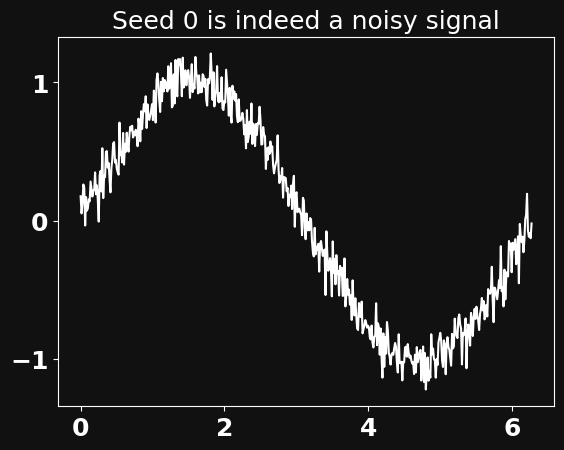

In [6]:
x,y = np.loadtxt(G[0]).T
plt.figure()
plt.plot(x,y,'w-')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Seed 0 is indeed a noisy signal',fontsize=18)
plt.gcf().set_facecolor('#111111');

Recovering the Mean signal
---

Here two methods are presented for recovering the mean signal. 

The first method, slightly slower, uses an explicit loop. 

The second method uses a list comprehension.

Why is one method faster than the other? 

Because the explicit loop uses more high-level (and slow) python interpretation between executions of very fast C code.

In [7]:
%%time
# Note that the zeroth file is already read
D = y
for k,g in enumerate(G):
    if k > 0:
        x,y = np.loadtxt(g).T
        D += y
M = D / k

CPU times: user 365 ms, sys: 195 ms, total: 560 ms
Wall time: 634 ms


In [8]:
%%time
D = np.array([ np.loadtxt(g).T[1] for g in G ])
M = np.mean(D,axis=0)

CPU times: user 302 ms, sys: 54.4 ms, total: 357 ms
Wall time: 629 ms


In [9]:
%%time
L = []
for k,g in enumerate(G):
    L.append(np.loadtxt(g).T)

CPU times: user 317 ms, sys: 21.1 ms, total: 338 ms
Wall time: 448 ms


In [10]:
%%time
running_sum = 0
for x,y in L:
    running_sum += y
resulting_mean = running_sum / len(L)

CPU times: user 7.36 ms, sys: 0 ns, total: 7.36 ms
Wall time: 7.38 ms


In [11]:
%%time
D = np.array([ np.loadtxt(g).T[1] for g in G ])

CPU times: user 307 ms, sys: 42.8 ms, total: 350 ms
Wall time: 441 ms


In [12]:
%%time
M = np.mean(D,axis=0)

CPU times: user 841 µs, sys: 0 ns, total: 841 µs
Wall time: 488 µs


### Mean signal

Now that the mean signal is recovered in memory, we can visualize:

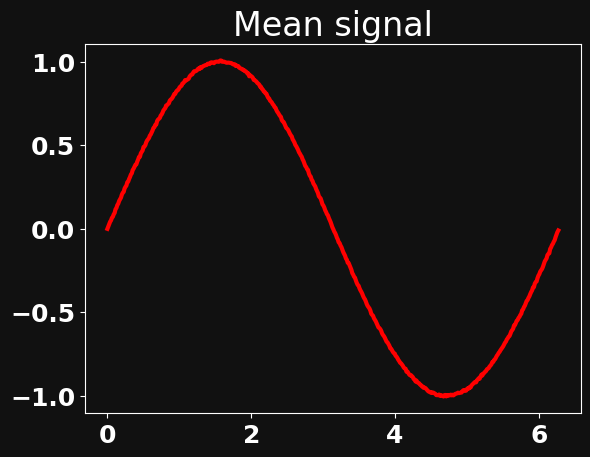

In [13]:
plt.plot(x,M,'r-',lw=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Mean signal')
plt.gcf().set_facecolor('#111111');

Signal Perturbation
---

What about the accumulated noise?

Note that `D` and `M` have different shapes, yet python's numpy is smart enough to figure it out

In [14]:
print(D.shape)
print(M.shape)

(1000, 500)
(500,)


In [15]:
%%time
# Slow explicit method

# initialize object
dZ = 0*D
for k,d in enumerate(D):
    dZ[k] = d - M

CPU times: user 1.26 ms, sys: 5.41 ms, total: 6.68 ms
Wall time: 2.21 ms


In [16]:
%%time
# Fast list comprehension way from previous example
dY = np.array([d - M for d in D])

CPU times: user 1.86 ms, sys: 1.78 ms, total: 3.64 ms
Wall time: 3.62 ms


In [17]:
%%time
# Significantly faster method
dX = D - M

CPU times: user 181 µs, sys: 296 µs, total: 477 µs
Wall time: 426 µs


In [18]:
# Verification
print(abs(dX-dZ).max())
print(abs(dX-dY).max())


0.0
0.0


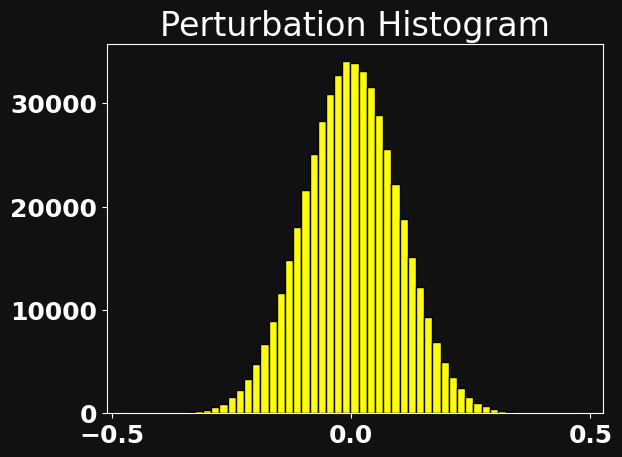

In [19]:
# Visualization (change the bin number)
plt.hist(dX.flatten(),bins=55,edgecolor='k',facecolor='#ffff00')
plt.title('Perturbation Histogram',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gcf().set_facecolor('#111111');

In [20]:
R0 = np.random.rand(10**9)
R1 = R0.copy()
R2 = R0.copy()
R3 = R0.copy()

In [21]:
%%time
for k in tqdm.tqdm(range(len(R1))):
  if R1[k] < 0.5:
    R1[k]=0
  else:
    R1[k]=1

100%|██████████████████████████████████████████████████████████████████████████| 1000000000/1000000000 [04:35<00:00, 3633423.02it/s]

CPU times: user 4min 34s, sys: 320 ms, total: 4min 34s
Wall time: 4min 35s


In [22]:
%%time
R2[R2<0.5] = 0
R2[R2>=0.5]= 1

CPU times: user 9.01 s, sys: 739 ms, total: 9.75 s
Wall time: 9.78 s


In [23]:
%%time
mask = R3<0.5
R3[mask] = 0
R3[~mask]= 1

CPU times: user 8.72 s, sys: 427 ms, total: 9.15 s
Wall time: 9.18 s


In [24]:
%%time
R4 = np.round(R0)

CPU times: user 361 ms, sys: 1.08 s, total: 1.44 s
Wall time: 1.45 s


### For More, scipy-lectures are recommended: [https://scipy-lectures.org/](https://scipy-lectures.org/)